In [1]:
from mcda.matrices import PerformanceTable
from mcda.scales import QuantitativeScale, PreferenceDirection
from mcda.outranking.electre import Electre3
from mcda.outranking.promethee import Promethee1, Promethee2
import numpy as np
from mcda.functions import VShapeFunction
from mcda.relations import PreferenceStructure
from helper_functions import dict_to_matrix, dict_to_matrix_with_prefix, net_flow_score, net_flow_score_pos_neg, create_preference_matrix, outranking_ranking, resolve_matrix_preferences, visualize_outranking

from new_methods.crisp_partial import crisp_partial
from new_methods.electre_partial import electre_partial
from new_methods.promethee_partial import promethee_partial

from new_methods.crisp_complete import crisp_complete
from new_methods.electre_complete import electre_complete
from new_methods.promethee_complete import promethee_complete
from hassediagram import plot_hasse


In [2]:
labels = ["A1", "A2", "A3", "A4", "A5", "A6", "A7"]

In [3]:
weights = [8, 4, 7, 2, 5]

In [4]:
# Definicja alternatyw
alternatives = [
    "A1",
    "A2",
    "A3",
    "A4",
    "A5",
    "A6",
    "A7"
]

# Definicja skali dla każdego kryterium
scales = {
    0: QuantitativeScale(1000, 4000, preference_direction=PreferenceDirection.MIN),# Price 
    1: QuantitativeScale(32, 1024, preference_direction=PreferenceDirection.MAX),    # Memory Size
    2: QuantitativeScale(8, 120, preference_direction=PreferenceDirection.MAX),     # Camera 
    3: QuantitativeScale(0, 5, preference_direction=PreferenceDirection.MAX),      # Functionalities 
    4: QuantitativeScale(12, 32, preference_direction=PreferenceDirection.MAX),      # Battery life
}

dataset = PerformanceTable(
    [[2200, 128, 120, 3, 16], [2800, 128, 16, 4, 28], [1200, 256, 120, 4, 12], [3400, 64, 16, 3, 24], [1600, 256, 32, 2, 20], [1000, 64, 32, 4, 26], [3200, 128, 64, 4, 22]],
    alternatives=alternatives, scales=scales
)
# Wagi kryteriów
W = {
    0: weights[0],  # Price 
    1: weights[1],   # Memory Size
    2: weights[2],  # Camera 
    3: weights[3],  # Functionalities 
    4: weights[4]   # Battery life
}

# Parametry Electre III

I = {0: 300, 1: 64,  2: 12, 3: 2,      4: 2}
P = {0: 600, 1: 256, 2: 32, 3: 3,      4: 6}
V = {0: 900, 1: 512, 2: 64, 3: np.inf, 4: 12}

In [5]:
electre3 = Electre3(performance_table=dataset, 
                    criteria_weights=W, 
                    indifference_thresholds=I, 
                    preference_thresholds=P, 
                    veto_thresholds=V)

In [6]:
electre_matrix = electre3.construct().data

# relacje

In [7]:
electre_matrix

,A1,A2,A3,A4,A5,A6,A7
A1,1.000000,0.000000,0.0,0.807692,0.544872,0.0,0.807692
A2,0.000000,1.000000,0.0,1.000000,0.000000,0.0,0.730769
A3,0.903846,0.000000,1.0,0.000000,0.807692,0.0,0.807692
A4,0.000000,0.596154,0.0,1.000000,0.000000,0.0,0.730769
A5,0.000000,0.807692,0.0,0.903846,1.000000,0.5,0.730769
A6,0.000000,1.000000,0.0,1.000000,0.897436,1.0,0.730769
A7,0.000000,0.705128,0.0,1.000000,0.000000,0.0,1.000000


In [8]:
credibility = electre_matrix
reversed_matrix = credibility.T

positive_preference_matrix = np.minimum(credibility, 1 - reversed_matrix)
negative_preference_matrix = np.minimum(1 - credibility, reversed_matrix)
indifference_matrix = np.minimum(credibility, reversed_matrix)
incomparible_matrix = np.minimum(1 - credibility, 1 - reversed_matrix)

In [9]:
positive_preference_matrix

,A1,A2,A3,A4,A5,A6,A7
A1,0.000000,0.000000,0.0,0.807692,0.544872,0.000000,0.807692
A2,0.000000,0.000000,0.0,0.403846,0.000000,0.000000,0.294872
A3,0.903846,0.000000,0.0,0.000000,0.807692,0.000000,0.807692
A4,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
A5,0.000000,0.807692,0.0,0.903846,0.000000,0.102564,0.730769
A6,0.000000,1.000000,0.0,1.000000,0.500000,0.000000,0.730769
A7,0.000000,0.269231,0.0,0.269231,0.000000,0.000000,0.000000


In [10]:
negative_preference_matrix

,A1,A2,A3,A4,A5,A6,A7
A1,0.000000,0.000000,0.903846,0.0,0.000000,0.000000,0.000000
A2,0.000000,0.000000,0.000000,0.0,0.807692,1.000000,0.269231
A3,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
A4,0.807692,0.403846,0.000000,0.0,0.903846,1.000000,0.269231
A5,0.544872,0.000000,0.807692,0.0,0.000000,0.500000,0.000000
A6,0.000000,0.000000,0.000000,0.0,0.102564,0.000000,0.000000
A7,0.807692,0.294872,0.807692,0.0,0.730769,0.730769,0.000000


In [11]:
indifference_matrix

,A1,A2,A3,A4,A5,A6,A7
A1,1.0,0.000000,0.0,0.000000,0.0,0.0,0.000000
A2,0.0,1.000000,0.0,0.596154,0.0,0.0,0.705128
A3,0.0,0.000000,1.0,0.000000,0.0,0.0,0.000000
A4,0.0,0.596154,0.0,1.000000,0.0,0.0,0.730769
A5,0.0,0.000000,0.0,0.000000,1.0,0.5,0.000000
A6,0.0,0.000000,0.0,0.000000,0.5,1.0,0.000000
A7,0.0,0.705128,0.0,0.730769,0.0,0.0,1.000000


In [12]:
incomparible_matrix

,A1,A2,A3,A4,A5,A6,A7
A1,0.000000,1.000000,0.096154,0.192308,0.455128,1.000000,0.192308
A2,1.000000,0.000000,1.000000,0.000000,0.192308,0.000000,0.269231
A3,0.096154,1.000000,0.000000,1.000000,0.192308,1.000000,0.192308
A4,0.192308,0.000000,1.000000,0.000000,0.096154,0.000000,0.000000
A5,0.455128,0.192308,0.192308,0.096154,0.000000,0.102564,0.269231
A6,1.000000,0.000000,1.000000,0.000000,0.102564,0.000000,0.269231
A7,0.192308,0.269231,0.192308,0.000000,0.269231,0.269231,0.000000


# partial

In [13]:
new_electre_partial = electre_partial(electre_matrix.values)

Restricted license - for non-production use only - expires 2026-11-23


c:\Users\Jurek\Desktop\Doktorat\nowe_repo\new_methods\electre_partial.py:66: DeprecationWarning: Model.display() is deprecated
  m.display()


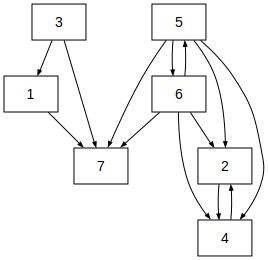

In [14]:
visualize_outranking(dict_to_matrix(new_electre_partial['solution_r']).astype(int))

In [15]:
new_electre_partial['objective_value']

17.99358974358974

In [16]:
dict_to_matrix(new_electre_partial['solution_R']).astype(int)

array([[1, 1, 0, 1, 1, 1, 0],
       [1, 1, 1, 0, 0, 0, 1],
       [0, 1, 1, 1, 1, 1, 0],
       [1, 0, 1, 1, 0, 0, 1],
       [1, 0, 1, 0, 1, 0, 0],
       [1, 0, 1, 0, 0, 1, 0],
       [0, 1, 0, 1, 0, 0, 1]])

In [17]:
dict_to_matrix_with_prefix(new_electre_partial['solution_P_minus']).astype(int)

array([[1, 0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 1, 1, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 1, 1, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 1, 0],
       [1, 0, 1, 0, 1, 1, 1]])

In [18]:
dict_to_matrix_with_prefix(new_electre_partial['solution_P_plus']).astype(int)

array([[1, 0, 0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0, 1],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 1, 0, 1, 1, 0, 1],
       [0, 1, 0, 1, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 1]])

In [19]:
dict_to_matrix(new_electre_partial['solution_I']).astype(int)

array([[1, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 1, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 0],
       [0, 0, 0, 0, 1, 1, 0],
       [0, 0, 0, 0, 0, 0, 1]])

In [20]:
dict_to_matrix(new_electre_partial['solution_r']).astype(int)

array([[1, 0, 0, 0, 0, 0, 1],
       [0, 1, 0, 1, 0, 0, 0],
       [1, 0, 1, 0, 0, 0, 1],
       [0, 1, 0, 1, 0, 0, 0],
       [0, 1, 0, 1, 1, 1, 1],
       [0, 1, 0, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 1]])

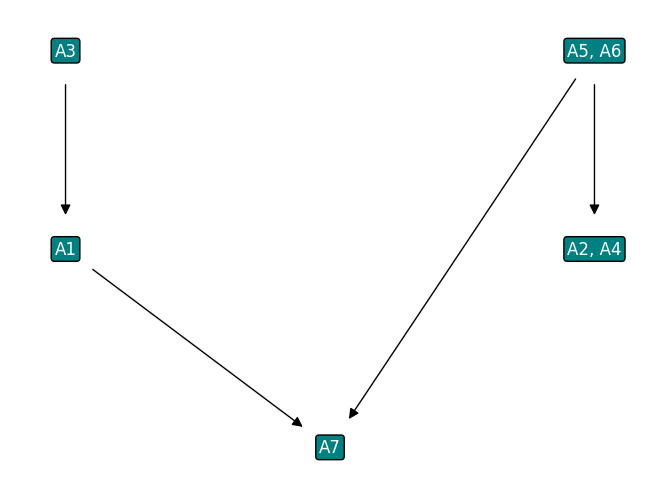

In [21]:
plot_hasse(dict_to_matrix(new_electre_partial['solution_r']).astype(int), labels)

# complete

In [22]:
new_electre_complete = electre_complete(electre_matrix.values)

c:\Users\Jurek\Desktop\Doktorat\nowe_repo\new_methods\electre_complete.py:54: DeprecationWarning: Model.display() is deprecated
  m.display()


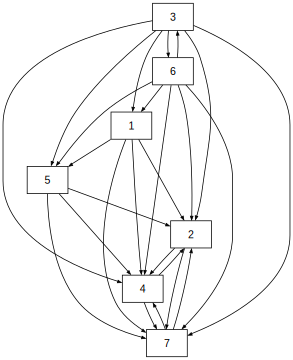

In [23]:
visualize_outranking(dict_to_matrix(new_electre_complete['solution_r']).astype(int))

In [24]:
new_electre_complete['objective_value']

25.17307692307692

In [25]:
dict_to_matrix(new_electre_complete['solution_z']).astype(int)

array([[1, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 1, 0, 0, 1],
       [0, 0, 1, 0, 0, 1, 0],
       [0, 1, 0, 1, 0, 0, 1],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0, 1, 0],
       [0, 1, 0, 1, 0, 0, 1]])

In [26]:
dict_to_matrix(new_electre_complete['solution_r']).astype(int)

array([[1, 1, 0, 1, 1, 0, 1],
       [0, 1, 0, 1, 0, 0, 1],
       [1, 1, 1, 1, 1, 1, 1],
       [0, 1, 0, 1, 0, 0, 1],
       [0, 1, 0, 1, 1, 0, 1],
       [1, 1, 1, 1, 1, 1, 1],
       [0, 1, 0, 1, 0, 0, 1]])

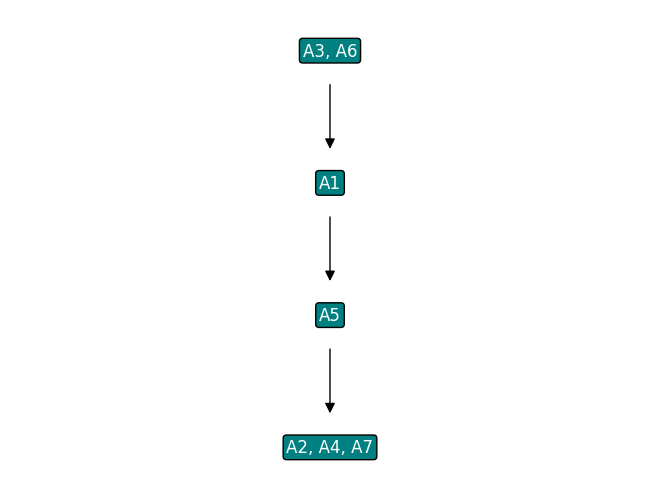

In [27]:
plot_hasse(dict_to_matrix(new_electre_complete['solution_r']).astype(int), labels)

# zestawienie

In [28]:
import pandas as pd

# partial

In [29]:
#P+
p_plus = pd.DataFrame(np.multiply(positive_preference_matrix, dict_to_matrix_with_prefix(new_electre_partial['solution_P_plus']).astype(int)));p_plus

,A1,A2,A3,A4,A5,A6,A7
A1,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.807692
A2,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000
A3,0.903846,0.000000,0.0,0.000000,0.0,0.0,0.807692
A4,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000
A5,0.000000,0.807692,0.0,0.903846,0.0,0.0,0.730769
A6,0.000000,1.000000,0.0,1.000000,0.0,0.0,0.730769
A7,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000


In [30]:
#P-
p_minus = pd.DataFrame(np.multiply(negative_preference_matrix, dict_to_matrix_with_prefix(new_electre_partial['solution_P_minus']).astype(int)));p_minus

,A1,A2,A3,A4,A5,A6,A7
A1,0.000000,0.0,0.903846,0.0,0.000000,0.000000,0.0
A2,0.000000,0.0,0.000000,0.0,0.807692,1.000000,0.0
A3,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0
A4,0.000000,0.0,0.000000,0.0,0.903846,1.000000,0.0
A5,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0
A6,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0
A7,0.807692,0.0,0.807692,0.0,0.730769,0.730769,0.0


In [31]:
#I
indiff = pd.DataFrame(np.multiply(indifference_matrix, dict_to_matrix(new_electre_partial['solution_I']).astype(int)));indiff

,A1,A2,A3,A4,A5,A6,A7
A1,1.0,0.000000,0.0,0.000000,0.0,0.0,0.0
A2,0.0,1.000000,0.0,0.596154,0.0,0.0,0.0
A3,0.0,0.000000,1.0,0.000000,0.0,0.0,0.0
A4,0.0,0.596154,0.0,1.000000,0.0,0.0,0.0
A5,0.0,0.000000,0.0,0.000000,1.0,0.5,0.0
A6,0.0,0.000000,0.0,0.000000,0.5,1.0,0.0
A7,0.0,0.000000,0.0,0.000000,0.0,0.0,1.0


In [32]:
#R
incomp = pd.DataFrame(np.multiply(incomparible_matrix, dict_to_matrix(new_electre_partial['solution_R']).astype(int)));incomp

,A1,A2,A3,A4,A5,A6,A7
A1,0.000000,1.000000,0.000000,0.192308,0.455128,1.0,0.000000
A2,1.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.269231
A3,0.000000,1.000000,0.000000,1.000000,0.192308,1.0,0.000000
A4,0.192308,0.000000,1.000000,0.000000,0.000000,0.0,0.000000
A5,0.455128,0.000000,0.192308,0.000000,0.000000,0.0,0.000000
A6,1.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.000000
A7,0.000000,0.269231,0.000000,0.000000,0.000000,0.0,0.000000


In [33]:
p_plus + p_minus + indiff + incomp

,A1,A2,A3,A4,A5,A6,A7
A1,1.000000,1.000000,0.903846,0.192308,0.455128,1.000000,0.807692
A2,1.000000,1.000000,1.000000,0.596154,0.807692,1.000000,0.269231
A3,0.903846,1.000000,1.000000,1.000000,0.192308,1.000000,0.807692
A4,0.192308,0.596154,1.000000,1.000000,0.903846,1.000000,0.000000
A5,0.455128,0.807692,0.192308,0.903846,1.000000,0.500000,0.730769
A6,1.000000,1.000000,1.000000,1.000000,0.500000,1.000000,0.730769
A7,0.807692,0.269231,0.807692,0.000000,0.730769,0.730769,1.000000


# complete

In [34]:
pref = pd.DataFrame(np.multiply(positive_preference_matrix, dict_to_matrix(new_electre_complete['solution_r']).astype(int)));pref

,A1,A2,A3,A4,A5,A6,A7
A1,0.000000,0.000000,0.0,0.807692,0.544872,0.0,0.807692
A2,0.000000,0.000000,0.0,0.403846,0.000000,0.0,0.294872
A3,0.903846,0.000000,0.0,0.000000,0.807692,0.0,0.807692
A4,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000
A5,0.000000,0.807692,0.0,0.903846,0.000000,0.0,0.730769
A6,0.000000,1.000000,0.0,1.000000,0.500000,0.0,0.730769
A7,0.000000,0.269231,0.0,0.269231,0.000000,0.0,0.000000


In [35]:
indiff = pd.DataFrame(np.multiply(indifference_matrix, dict_to_matrix(new_electre_complete['solution_z']).astype(int)));indiff

,A1,A2,A3,A4,A5,A6,A7
A1,1.0,0.000000,0.0,0.000000,0.0,0.0,0.000000
A2,0.0,1.000000,0.0,0.596154,0.0,0.0,0.705128
A3,0.0,0.000000,1.0,0.000000,0.0,0.0,0.000000
A4,0.0,0.596154,0.0,1.000000,0.0,0.0,0.730769
A5,0.0,0.000000,0.0,0.000000,1.0,0.0,0.000000
A6,0.0,0.000000,0.0,0.000000,0.0,1.0,0.000000
A7,0.0,0.705128,0.0,0.730769,0.0,0.0,1.000000
